In [1]:
###-------------
### code from https://blog.csdn.net/qq_43012160/article/details/99305856
### re-run by Yazhou
### 2019- 12-16

In [69]:
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### 1.1读取数据

In [106]:
train_data = pd.read_csv("titanic_train.csv")
test_data  = pd.read_csv("test.csv") #lineterminator
test_Lable = pd.read_csv("mygender.csv") # ground truth 
testLable  = list(map(int,test_Lable['Survived']))

train_data = train_data.drop(['PassengerId'],axis=1)
test_data  = test_data.drop(['PassengerId'],axis=1)
train_data = train_data.drop(['Name'],axis=1)
test_data  = test_data.drop(['Name'],axis=1)
train_data = train_data.drop(['Cabin'],axis=1)
test_data  = test_data.drop(['Cabin'],axis=1)
train_data = train_data.drop(['Ticket'],axis=1)
test_data  = test_data.drop(['Ticket'],axis=1)
#print("训练样本个数:",train_data.shape[0]),print("测试样本个数:",test_data.shape[0])

### 1.3 训练集合中缺失的数据集合 - 是可以直接删除的

In [107]:
train_data.dropna(axis=0,inplace=True)
trainLen = len(train_data)
testLen  = len(test_data)
#训练集标签特征分离：
trainLable= list(map(int,train_data['Survived']))
train_data=train_data.drop(['Survived'],axis=1)
print(train_data.columns)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')


In [108]:
trainLEN = len(train_data)
testLEN = len(test_data)
trainLEN,testLEN

(712, 418)

### 1.5 对于测试样本中缺失的值不能直接删除，要选择合适值来填充

In [109]:
### 对'Fare' 填充众数 = test_data['Fare'].dropna().mode()
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].dropna().mode()[0])

### 1.6考虑到数据间的量纲问题，对数据进行归一化处理

In [110]:
combineData = train_data.append(test_data)
combineData.columns,len(combineData)

(Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object'),
 1130)

In [111]:
## 下面的代码是在7个特征数据的基础上，对['Sex','Embarked']两列做编码处理了
columns = ['Sex','Embarked']
Temp_data   = combineData
result      = []
le          = LabelEncoder()
ListData_tmp= []
for column in columns:
    ListData = []
    for review in Temp_data[column]:
        ListData.append(review)
    Temp_data[column] = le.fit_transform(ListData)
    ListData_tmp.append(ListData)

###对1130*7的数据中做全部的遍历
for rowIndex in range(len(Temp_data)):
    rowVec = []
    for columnIndex in range(0,len(Temp_data.columns)):
        if columnIndex!=2: # 跳过"Age"列
            rowVec.append(Temp_data.iloc[rowIndex,columnIndex])
    result.append(rowVec)

scl                = MinMaxScaler()
combine_result_fit = scl.fit_transform(np.array(result))
combine_train      = combine_result_fit[0:trainLEN]
combine_test       = combine_result_fit[trainLEN:trainLEN + testLEN]

In [112]:
np.array(Temp_data).shape,combineData.shape,combine_train.shape,combine_test.shape

((1130, 7), (1130, 7), (712, 6), (418, 6))

### 对Age非空的数据重新编码

In [113]:
Full_Age_data  = combineData['Age']
AgeisNull      = Full_Age_data.isnull().get_values() 
AgeNotNullData = []
Full_Age_List  = []
Age_Test_inModel  = []
Age_Train_inModel = []
for i in Full_Age_data:
    Full_Age_List.append(i)


for i in range(0,len(AgeisNull)):
    if AgeisNull[i] == False: # 非空元素
        AgeNotNullData.append(Full_Age_List[i])
        Age_Train_inModel.append(combine_result_fit[i,:])
    else:
        Age_Test_inModel.append(combine_result_fit[i,:])

AgeNotNullData = np.array(AgeNotNullData)
AgeNotNullData = AgeNotNullData.reshape(1,-1)
Age_notNull_encode_label = scl.fit_transform(AgeNotNullData)
Age_Train_label = Age_notNull_encode_label.reshape(-1,1)
Age_Train_Data  = np.array(Age_Train_inModel)

# need prediction 
Age_Test_inModel = np.array(Age_Test_inModel)

In [114]:
Age_Train_label.shape,Age_Train_Data.shape,Age_Test_inModel.shape

((1044, 1), (1044, 6), (86, 6))

In [115]:
ageLable = Age_Train_label
ageTrain = Age_Train_Data
ageTest  = Age_Test_inModel
#预测Age：
print('预测测试集Age:')
model1 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                                  learning_rate=0.03, loss='huber', max_depth=15,
                                  max_features='sqrt', max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=10, min_samples_split=40,
                                  min_weight_fraction_leaf=0.0, n_estimators=300,
                                  presort='auto', random_state=10, subsample=0.8, verbose=0,
                                  warm_start=False)#创建mlp神经网络对象
model2 = MLPRegressor(activation='tanh', learning_rate='adaptive')
age_sum = []

max_iters = 5
for i in range(0,max_iters):
    print(i,'th training:')
    model1.fit(ageTrain,ageLable)#模型训练
    age_model1 = model1.predict(ageTest)#模型预测
    model2.fit(ageTrain,ageLable)#模型训练
    age_model2 = model2.predict(ageTest)#模型预测
    age_sum.append(age_model1*0.5+age_model2*0.5)

age_model = []
for i in range(len(ageTest)):
    asum=0
    for j in range(0,max_iters):
        asum=asum+age_sum[j][i]
    age_model.append(asum/max_iters)

print("Age的空值将被age_model的值来代替")

预测测试集Age:
0 th training:
1 th training:


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 th training:
3 th training:
4 th training:
Age的空值将被age_model的值来代替


In [116]:
NullIndex = []
combineData_age_array = np.array(combineData['Age'])
for i in range(0,len(AgeisNull)):
    if AgeisNull[i] == True:
        NullIndex.append(i)
for i in range(len(NullIndex)):
    nullindex = NullIndex[i]
    combineData.iloc[nullindex,2] = age_model[i]

In [117]:
combineData.shape

(1130, 7)

In [118]:
#去除离群点：
magicdata = 6
trainReview = combineData[0:trainLEN]
trainReview = np.array(trainReview)
rowLen=trainReview.shape[1]
shallDel=[]
for i in range(0,len(trainReview)):
    shallDel.append(0)
    
for j in range(0,rowLen):
    min = np.percentile(trainReview[:,j],magicdata)
    max = np.percentile(trainReview[:, j], 100 - magicdata)
    for i in range(0, len(trainReview)):
        if (trainReview[i,j]<min) or (trainReview[i,j]>max):shallDel[i]=1
for i in range(len(trainReview)-1,-1,-1):
    if shallDel[i]==1:
        trainReview=np.delete(trainReview,i,axis=0)
        trainLable = np.delete(trainLable, i, axis=0)

In [119]:
trainLable.shape,trainReview.shape

((525,), (525, 7))

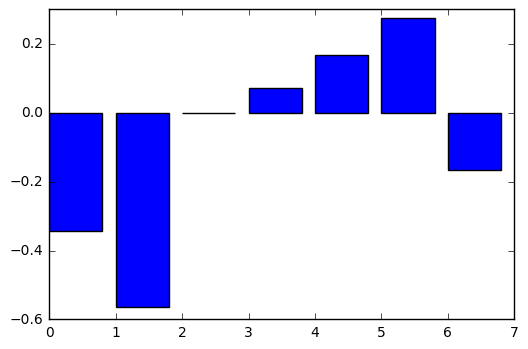

In [120]:
rowLen=trainReview.shape[1]
dfCorr=[]
srLable = pd.Series(trainLable)
for i in range(0,rowLen):
    srReview=pd.Series(trainReview[:,i])
    dfCorr.append(srReview.corr(srLable,method='kendall'))
plt.bar(list(range(0,rowLen)),dfCorr)
plt.show()

In [121]:
import pandas as pd
import math
x=[]
y=[]
for i in range(1,101):
    x.append(i)
    y.append(math.log(i**2+math.log(i**0.5+40*i))+i**2+i**6+i**math.log(i**math.sqrt(2*i)))
print(pd.Series(x).corr(pd.Series(y),method='pearson'))
print(pd.Series(x).corr(pd.Series(y),method='kendall'))
print(pd.Series(x).corr(pd.Series(y),method='spearman'))


0.18299213984
1.0
1.0


In [122]:
import pandas as pd
import math
x=[]
y=[]
for i in range(1,101):
    x.append(i)
    y.append(math.cos(math.log(i**2+math.log(i**0.5+40*i))+math.sin(i**2+i**6+i**math.log(i**math.sqrt(2*i))))**3)
print(pd.Series(x).corr(pd.Series(y),method='pearson'))
print(pd.Series(x).corr(pd.Series(y),method='kendall'))
print(pd.Series(x).corr(pd.Series(y),method='spearman'))

-0.464060281958
-0.349090909091
-0.478787878788


In [123]:
print('建模:')
testReview       = combineData[trainLEN:trainLEN + testLEN]
model            = LogisticRegression()
model.fit(trainReview, trainLable)
print('预测:')
pred_model = model.predict(testReview)
score  = metrics.accuracy_score(testLable, pred_model)
matrix = metrics.confusion_matrix(testLable, pred_model)
print('>>>准确率\n', score)
print('\n>>>混淆矩阵\n', matrix)

建模:
预测:
>>>准确率
 0.925837320574

>>>混淆矩阵
 [[244  22]
 [  9 143]]


In [132]:
pred_model.shape,len(testLable)

((418,), 418)

In [143]:
100*25/481

5.197505197505198

In [141]:
pred_model_ = list(pred_model)
CorrectIndex = 0
for i in range(0,len(pred_model)):
    if testLable[i] == pred_model_[i]:
        CorrectIndex+=1
print("Accuracy is:%0.3f"%(100*CorrectIndex/len(pred_model_)),'%')

Accuracy is:92.584 %


In [144]:
### 下面获得准确率大约是80%
pre_y = pred_model
test_data_  = pd.read_csv("test.csv") #lineterminator
pred_y = pre_y.astype(int)
PassengerId = test_data_.loc[:,'PassengerId']
pred_DF = pd.DataFrame({'PassengerId':PassengerId,
                        'Survived':pred_y})
pred_DF.to_csv("taitannike_predict_v2.csv",index = False)
print(pred_DF.shape)
pred_DF.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
